# Predict your Future Connections on Facebook
- [Reference](https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/?utm_source=blog&utm_medium=introduction-graph-theory-applications-python)

In [0]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pwd
os.chdir('gdrive/My Drive/Colab Notebooks/')
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks
 abcnews-date-text.csv
 ab_data.csv
'A B Test.ipynb'
 AirPassengers.csv
'A method to categorical variable in flight delay datasets.ipynb'
'ARIMA Forecasting.ipynb'
 assignment0.ipynb
'assignment2_(release).ipynb'
 assignment2_sol.ipynb
 Automotive_5.json
'Building a Simple Chatbot.ipynb'
 chatbot.txt
'Classifying Tweets for Sentiment Analysis.ipynb'
'Community Detection.ipynb'
'Concrete Compressive Strength Pr

In [4]:
# load nodes details
with open("fb-pages-food.nodes") as f:
    fb_nodes = f.read().splitlines() 

# load edges (or links)
with open("fb-pages-food.edges") as f:
    fb_links = f.read().splitlines() 

len(fb_nodes), len(fb_links)

(621, 2102)

In [5]:
# captture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 2102/2102 [00:00<00:00, 451591.82it/s]


In [6]:
fb_df.head()

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


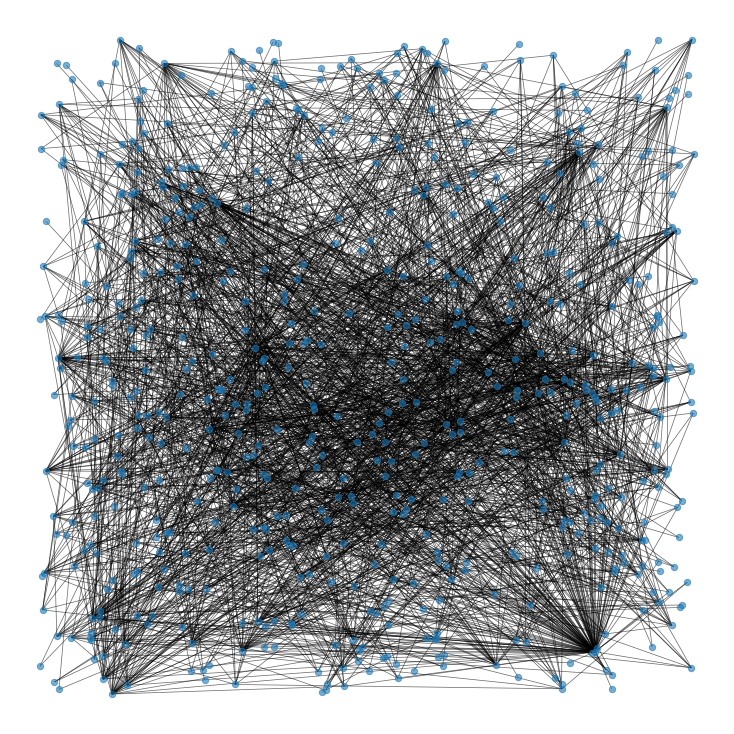

In [7]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

This is what we are going to deal with – a wire mesh of Facebook pages (blue dots). The black lines are the links or edges connecting all the nodes to each other.

# Dataset Preparation for Model Building

## Retrieve Unconnected Node Pairs – Negative Samples

In [0]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [9]:
adj_G.shape

(620, 620)

In [10]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 620/620 [00:08<00:00, 69.90it/s] 


In [11]:
len(all_unconnected_pairs)

19018

In [0]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

## Remove Links from Connected Node Pairs – Positive Samples

In [13]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 2102/2102 [00:08<00:00, 234.07it/s]


In [14]:
len(omissible_links_index)

1483

## Data for Model Training

In [0]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [16]:
data['link'].value_counts()

0    19018
1     1483
Name: link, dtype: int64

## Feature Extraction

In [0]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [18]:
!pip install node2vec

In [19]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


In [20]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


## Building our Link Prediction Model



In [0]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [22]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
predictions = lr.predict_proba(xtest)

In [24]:
roc_auc_score(ytest, predictions[:,1])

0.809102817607873

In [25]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

[1]	valid_0's auc: 0.717444
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.752059
[3]	valid_0's auc: 0.769158
[4]	valid_0's auc: 0.790985
[5]	valid_0's auc: 0.810254
[6]	valid_0's auc: 0.81485
[7]	valid_0's auc: 0.817744
[8]	valid_0's auc: 0.824237
[9]	valid_0's auc: 0.833005
[10]	valid_0's auc: 0.839582
[11]	valid_0's auc: 0.844226
[12]	valid_0's auc: 0.847929
[13]	valid_0's auc: 0.851395
[14]	valid_0's auc: 0.856252
[15]	valid_0's auc: 0.858606
[16]	valid_0's auc: 0.860201
[17]	valid_0's auc: 0.865258
[18]	valid_0's auc: 0.867315
[19]	valid_0's auc: 0.868609
[20]	valid_0's auc: 0.869882
[21]	valid_0's auc: 0.872949
[22]	valid_0's auc: 0.876481
[23]	valid_0's auc: 0.879468
[24]	valid_0's auc: 0.882669
[25]	valid_0's auc: 0.884532
[26]	valid_0's auc: 0.885934
[27]	valid_0's auc: 0.888407
[28]	valid_0's auc: 0.889834
[29]	valid_0's auc: 0.890141
[30]	valid_0's auc: 0.890526
[31]	valid_0's auc: 0.891838
[32]	valid_0's auc: 0.893468
[33]	valid_0's auc: 